# FITS data processing in python

Data reduction is a way to clean images taken from telescope from a variety of instrumental signatures.

The aim od data reduction is:
* Removal of instrumental signatures, like dark current and field curvature.
* Masking of unwanted signals, like cosmic rays, stellar halos and satellite tracks.
* Photometric and Astrometric Calibration. 
* Coaddition of individual frames.


A number of program packages exist to perform data reduction steps:
* The old style (but still used)  IRAF and MIDAS.
  * These are very powerful packages but technologically they are dinosaurs in many aspects.
* A number of standalone programs for specific tasks exists as well.
* New instruments now often come with automatic data reduction pipelines.
* Python provides framworks to make data reduction: AstroPy

**What do I need to reduce my data?**

The scientific frame


In [77]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sci
from astropy.io import fits
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib
import scipy.ndimage as snd

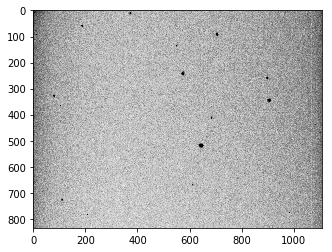

In [78]:
hdulist = fits.open("Dati/ima0001.fits")
plt.imshow(hdulist[0].data, cmap='Greys', vmax=2200,vmin=1500)

**The Bias Frame**

The bias is measured by taking zero second exposures with the shutter closed. 

CCD electronics add “overscan regions” at the edges, i.e., a few virtual columns. 
These can also be used to measure the bias.

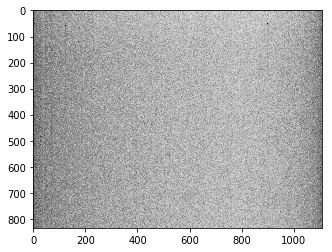

In [67]:
hdulist = fits.open("Dati/ima0010.fits")
plt.imshow(hdulist[0].data, cmap='Greys',vmax=2200,vmin=1500)

**The Dark Frame**

To measure the dark current a long exposure, 10 min or more, is taken with shutter closed. 

The only signal, except for bias of course, will be from thermal electrons.

__NOTE__ Most modern cameras are cooled with liquid N2 to 170 K. The dark current is negligible then.

We do not have a Dark Frame in this observations...and it is not because we have a liquidcooled CCD :-)

**The Flatfield Frame**

Flatfields can be obtained by:

* taking pictures of a uniformly illuminated screen inside the telescope dome (domeflats), 
* observing a blank field during twilight (sky flat), 
* using deep science exposures using the night sky directly (night sky flats).

Domeflats can be taken during the day without hurry. But uniform illumination is difficult. Also, the spectral energy distribution of lamps is different from the night sky.

The twilight sky spectrum is much closer to the night sky spectrum than lamps and it is very uniform over the field-of-view of cameras. But suitable twilight is very short, especially if one has to take flatfields for many filters.

Night sky flats (superflats) are ideal but they requires many deep observations at different positions on empty fields to sample the night sky several times at every pixel.

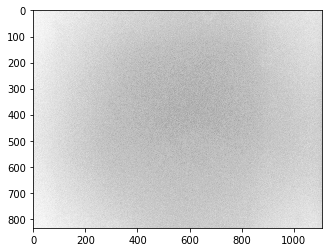

In [68]:
hdulist = fits.open("Dati/ima0008.fits")
plt.imshow(hdulist[0].data, cmap='Greys')

**Fringing**

Fringing is an additive – Newton-ring like – effect in red pass-bands caused by interference in the CCD substrate.

Fringe maps are produced by combining a number (as many as possible) of images with different pointings, allowing the removal of stars and other sources. The frames are first bias subtracted and flat fielded in the normal fashion, then averaged with rejection of the highest values at each pixel position to leave only the fringe pattern.

We do not produce finging pattern but here an example of how they look like.


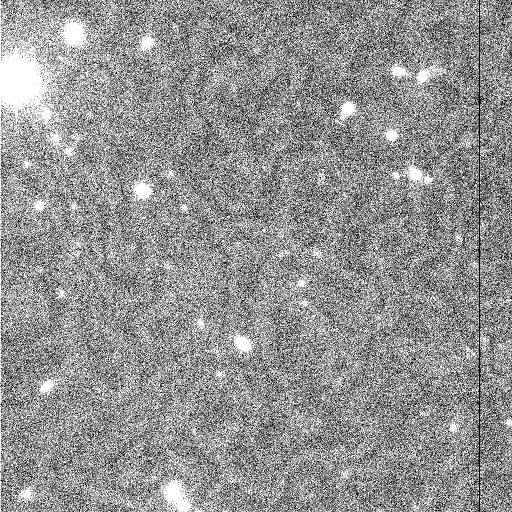

##  Image Reduction

Given that we have a series of images, flats, biases, and darks, we would like to perform image arithmetic on them to get the optimum image out.

Now we would like to first of all make a master flat, a master bias, and a master dark. This is necessary in order to reduce the effect of cosmic rays. In practice what we need to do to each CCD image is:

$ reduced = \frac{science-dark}{flat-bias}$

First we must compute the master images, it is obtained making  __median__ combine of the flats and biases (and Dark when available).

In [69]:
biases = np.array([fits.getdata("../Esempi/Riduzione Dati/DATA/BIAS/ima00%d.fits" % n) for n in range(10,17)])

In [70]:
biases.shape

(7, 834, 1108)

In [71]:
flats = np.array([fits.getdata("../Esempi/Riduzione Dati/DATA/FLAT/ima00%02d.fits" % n) for n in range(8,16)])

This is the BIAS frame

In [72]:
bias = np.median(biases, axis=0)

And the flat frame

In [73]:
flat = np.median(flats, axis=0)

The science data

In [74]:
rawdata = np.array([fits.getdata("../Esempi/Riduzione Dati/DATA/OBJ/ima0%03d.fits" % n) for n in range(1,211)])

In [75]:
rawdata.shape

(210, 834, 1108)

We load 210 images in one shot

In [76]:
final = (rawdata / (flat - bias)) * np.mean(flat-bias)

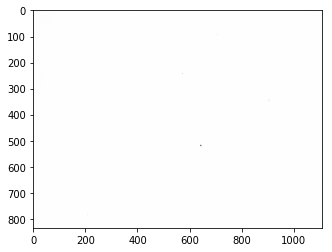

In [14]:
plt.imshow(final[0], cmap='Greys')

We barely see the stars, to better visualize them we can find how the pixels are distributed.

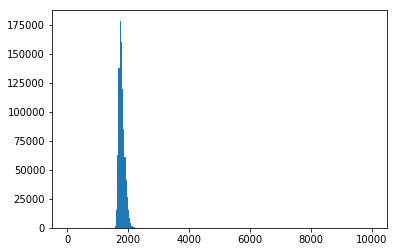

In [15]:
hist = plt.hist(final[0].ravel(), 256, range=(0.0, 10000.0))

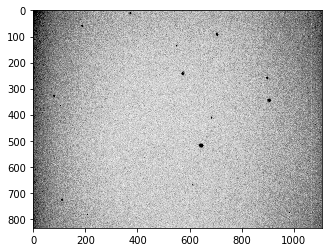

In [16]:
plt.imshow(final[0], cmap='Greys', vmax=2200,vmin=1500)

CCD detectors properties: 

* Dynamic range
* full well capacity
* saturation level. 


It’s important to choose an exposure time short enough so that objects of interest are not saturated! (But long enough so you are sky-noise limited).

We can check if a brigth star saturated the CCD.

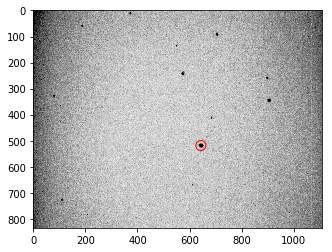

In [17]:
plt.imshow(final[0], cmap='Greys', vmax=2200,vmin=1500)
plt.scatter([643,],[518,],s=100, facecolors='none', edgecolors='r')

In [18]:
Z = final[0][505:530,635:655]
Y=np.arange(505,530)
X=np.arange(635,655)
X, Y = np.meshgrid(X, Y)

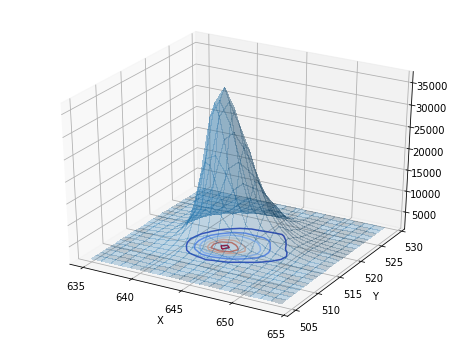

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z,  linewidth=0, rstride=1, cstride=1, alpha=0.25, antialiased=False)
cset = ax.contour(X, Y, Z, zdir='z', offset=-np.pi, cmap=matplotlib.cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-np.pi, cmap=matplotlib.cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=3*np.pi, cmap=matplotlib.cm.coolwarm)
tics = ax.set_xticks([635,640,645,650,655])
ax.set_xlabel('X')
ax.set_ylabel('Y')

Has the star satureted the CCD? What do you expect from a saturated star?

#### PSF fitting

We want to better understand what the Point Spread Function (PSF) looks like across our image. First we want to select some representative stars in our image, or at least one. We can do that in two different ways, one is to  open the fits file in DS9. Create a small region around some stars which are bright (but unsaturated) and which don't have any friends nearby. Save the regions to a file (making sure to save it in X Y format) and then open it in python.
The other possibility is to select a start directly in the python image.


In [20]:
import scipy.optimize

Let use our star, we can use some python approach (or also DS9 if yu like). In python a good way to find centroids  is simply using scipy's center of mass function.

In a region of the image where we expect to find our star (a slice of the array in `[620:680][480:550]`) we can tag all of the pixels which are larger than the threshold, defined here to be the mean of the image plus 4 standard deviations.

This will create a map of pixels which satisfy the threshold, which we hold in the variable array called labels (the number of stars is held in "num"). Then perform the center of mass calculation on each of these pixel chunks:

In [21]:
img=final[0][450:650,550:750].copy()

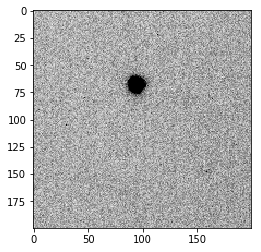

In [22]:
plt.imshow(img, cmap='Greys',clim=(1500,2000))

In [23]:
threshold = img.mean() + 2*img.std()
labels, num = snd.label(img > threshold, np.ones((3,3)))
centers = snd.center_of_mass(img, labels, range(1,num+1))
xint = int(centers[0][1])
yint = int(centers[0][0])

In [24]:
print(xint, yint)

93 67


This is the position of the center of mass of the star calculated before in the reference frame of the sub image (cutout)

Let us illustrate the _PSF_ fitting process. We will be fitting a Gaussian to only a line plot, also just for illustrative purposes. 

With your data you perhaps would want to fit more than one star, and in two dimensions, and maybe not even a Gaussian!

In [25]:
y=img[yint,:]
x = np.linspace(0,len(y)-1,len(y))

Now define an "anonymous function" in python (called a lambda form, or lambda), which will take in a set of parameters and output the function operated upon those parameters. Here we define a Gaussian as our fitting function. We also define a lambda that is the fitted function minus the data.

In [26]:
fitfunc = lambda p, x: p[0]*scipy.exp(-(x-p[1])**2/(2.0*p[2]**2))
errfunc = lambda p, x, y: fitfunc(p,x)-y

this function is minimized using scipy.

In [37]:
parameters,foo = scipy.optimize.leastsq(errfunc,(5000,85,3),args=(x,y))

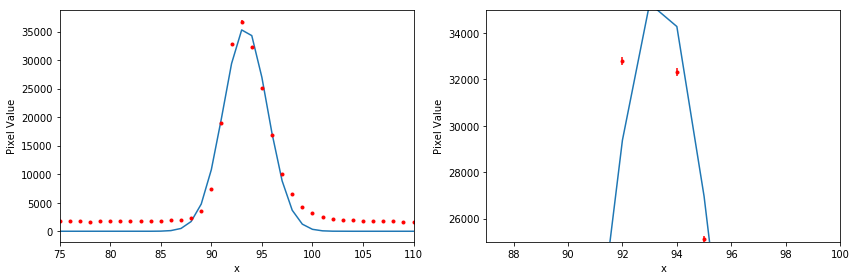

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_xlim([75,110])
axes[0].plot(x,fitfunc(parameters,x))
axes[0].errorbar(x,y,yerr=np.sqrt(y),fmt='r.')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Pixel Value')
axes[1].set_xlim([87,100])
axes[1].set_ylim([25000,35000])
axes[1].plot(x,fitfunc(parameters,x))
axes[1].errorbar(x,y,yerr=np.sqrt(y),fmt='r.')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Pixel Value')
fig.tight_layout()

### Flux and background

Once you have found a source you need to measure how bright it is. With CCD data this is simply a matter of determining the total value of pixels contributing to the source, minus any background light. Subtracting off the total background contribution to the counts is very important because you will otherwise get a value for the brightness of your source which is much too high.

There are many ways to estimate the flux of a source and to subtract off the background to such a measurement. 

One simple way to do this is to count the total value of all the pixels within a fixed distance from the source. 
This is so-called _aperture photometry_, because it is equivalent to observing the source with a fixed aperture size. 

A reasonable value to pick for this is a diameter of 3” (equivalent to about 9 pixels) 

**Question** How can we estimeate this value? Use the Image Header.  


To calculate the contribution of the background, an annular reference aperture can be used to calculate the local background to the object, in terms of counts-per-pixel. 

You can then multiply the background in counts per pixel by the number of pixels in your source aperture to work out the total background contribution to the aperture flux. 

This can then be subtracted from the aperture flux to give the flux due solely to the object.

To find the annular aperture first we must find a way to identify the star:

In [63]:
data=final[0].copy()
xint=644 # Star coordinates in the image
yint=518 #
r=9.2
x,y = np.ogrid[-xint:1108-xint, -yint:834-yint]

Now I acreate a mask to apply to the image that is 0 everyware except for pixels that are closer that `r` to the center of the star `[xint,yint]`

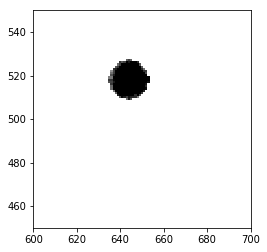

In [64]:
mask=x*x+y*y > r*r

data[mask.T]=0
plt.xlim([600,700])
plt.ylim([450,550])
plt.imshow(data, cmap='Greys',clim=(1500,2000))


__Execercise__: 

Make a python program that process all images and reduce them. Then:

* Using the same method, extract the annular frame and evaluate the background. Then evaluate the flux and subtract the backgound.
* Evaluate the flux of the start in each image;
* Plot the flux vs time to estimate the variability period
* Plot the flux vs time expressed in Heliocentric Julian Date at exposure midpoint